## Data preprosesing

### Identify missing values
Convert <b>"?"</b> to NaN and rename columnn for great convenience.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold

INTEGER_COLUMN = ["symboling",
                "wheel_base",
                "num_of_doors",
                "length","width",
                "height",
                "curb_weight",
                "num_of_cylinders",
                "engine_size",
                "bore",
                "stroke",
                "compression_ratio",
                "horsepower",
                "peak_rpm",
                "city_mpg",
                "highway_mpg",
                "price"]

raw_data = pd.read_csv('dataset/VehicleDataset.csv')
raw_data.columns = [column.lower().replace("-", "_").replace(" ", "_") for column in raw_data.columns]

df=raw_data.copy()
df.replace('?', np.nan, inplace = True)

C:\Users\garik\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Check count messing value in each column
Each column has 205 rows of data and 7 columns containing missing data:

1) <b> normalize losses </b>: 41 missing data
2) <b>num of doors</b> : 2 missing data
3) <b>bore</b> : 4 missing data
4) <b>stroke</b> : 4 missing data
5) <b>horsepower</b> : 2 missing data
6) <b>peak rpm</b> : 2 missing data
7) <b>price</b>  : 4 missing data

In [2]:
missing_data = df.isnull()
data_type = df.dtypes.values
data_isnotnull = [205, 164, 205, 205, 205, 203, 205, 205,205, 205,205,205, 205,205, 205,205,205, 205,201,201,205, 203,203,205,205,201]
data_null = [205-value for value in data_isnotnull]
str_data_null = [str(x) for x in data_null]
str_data_isnotnull = [str(x) for x in data_isnotnull]
column = missing_data.columns.values.tolist()

data = np.array([column, data_type, data_isnotnull, data_null], dtype=str).T
print(tabulate(data, headers=["Name","Type","No Null", "Null"]))

Name               Type       No Null    Null
-----------------  -------  ---------  ------
symboling          int64          205       0
normalized_losses  object         164      41
make               object         205       0
fuel_type          object         205       0
aspiration         object         205       0
num_of_doors       object         203       2
body_style         object         205       0
drive_wheels       object         205       0
engine_location    object         205       0
wheel_base         float64        205       0
length             float64        205       0
width              float64        205       0
height             float64        205       0
curb_weight        int64          205       0
engine_type        object         205       0
num_of_cylinders   object         205       0
engine_size        int64          205       0
fuel_system        object         205       0
bore               object         201       4
stroke             object         

### Data analysis 
<ul>
<li><b>84.04%</b> Sedan is four doors.<br>
    It was reasonable if missed data for the number of doors will be replace by four.<br></li>
    <li>Missed data with <b>natural numbers</b> can be replace by <b>mean</b> value whole column. </li>
    <li>Missed price data will be deleted, because price is what we want predict. Any data entry without price data cannot be used for prediction.</li>
</ul>

In [3]:
print(raw_data.loc[:,["num_of_doors", "body_style"]].groupby("body_style").value_counts(), 
      "\n{}% sedan is four doors.".format(round(79/(79+15)*100,2)))

body_style   num_of_doors
convertible  two              6
hardtop      two              8
hatchback    two             60
             four            10
sedan        four            79
             two             15
             ?                2
wagon        four            25
dtype: int64 
84.04% sedan is four doors.


### Replace missing values or drop value
<b>Replace by avg value:</b>
<ul>
    <li><b>normalized losses</b> : 41 missing data, replace them with mean</li>
    <li><b>stroke</b> : 4 missing data, replace them with mean</li>
    <li><b>bore</b> : 4 missing data, replace them with mean</li>
    <li><b>horsepower</b> : 2 missing data, replace them with mean</li>
    <li><b>peak-rpm</b> : 2 missing data, replace them with mean</li>
</ul>

<b>Replace by frequency:</b>
<ul>
    <li><b>num of doors</b> : 2 missing data, replace them with "four". 
    </li>
</ul>

<b>Drop the whole 4 rows:</b>
<ul>
    <li><b>price</b> : 4 missing data, simply delete the whole row</li>
</ul>

#### Replace

In [4]:
df.dropna(subset=["price"],axis=0,inplace=True)
df.num_of_doors.replace(np.nan,"four",inplace=True)
def Calculate_AVG_and_Replace(df, сolumns):
    for index, column in enumerate(сolumns):
        avg_value = df[column].astype("float").mean(axis=0)
        print("Average of {} : {}".format(column.replace("_", " "), round(avg_value,2)))
        df[column].replace(np.nan, avg_value, inplace=True)
    return df

def Convert_Type(df, columns, type_):
    df.num_of_doors = [convert_string_to_number(value) for value in df.num_of_doors.to_list()]  
    df.num_of_cylinders = [convert_string_to_number(value) for value in df.num_of_cylinders.to_list()] 
    for index, column in enumerate(columns):
        df[column] = df[column].astype(type_[index])
    
    return df

def convert_string_to_number(argument):
    switcher ={'two':2,'three':3,'four':4,'five':5,'six':6,'eight':8,'twelve':12}
    return switcher.get(argument,0)

df = Calculate_AVG_and_Replace(df, ["normalized_losses", "bore", "stroke", "horsepower", "peak_rpm"])


Average of normalized losses : 122.0
Average of bore : 3.33
Average of stroke : 3.26
Average of horsepower : 103.4
Average of peak rpm : 5117.59


#### Convert

In [5]:
df = Convert_Type(df, ["num_of_doors","num_of_cylinders","normalized_losses", "bore", "stroke", "horsepower", "peak_rpm", "price"], [int,int,int, float, float, int, int, float])

#### Delete 4-rows price 

In [6]:
df.dropna(subset=["price"],axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

#### Out

In [7]:
df.dtypes

symboling              int64
normalized_losses      int32
make                  object
fuel_type             object
aspiration            object
num_of_doors           int32
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders       int32
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower             int32
peak_rpm               int32
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

In [8]:
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,122,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,122,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,164,audi,gas,std,4,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,164,audi,gas,std,4,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Data normalization

In [9]:
### Add group-size column

In [10]:
def range_category(lower: float, upper: float, key):
    return lower <= key <= upper

def in_ft(value):
    return value * 0.083333

def GROUP_SIZE_CAR(curb_weight:float, S: float):
    if range_category(1400,2500,curb_weight) and range_category(55,80, S): return 'mini-size'
    if range_category(2001,2500,curb_weight) and range_category(80.0001,110, S): return 'small-size'
    if range_category(2001,2500,curb_weight) and range_category(110.0001,200, S): return 'medium-size'

    if range_category(2501,4000,curb_weight) and range_category(70,80, S): return 'small-size'
    if range_category(2501,3000,curb_weight) and range_category(80.0001,90, S): return 'small-size'
    if range_category(2501,3000,curb_weight) and range_category(90.0001,200, S): return 'medium-size'

    if range_category(3001,8000,curb_weight) and range_category(80.0001,90, S): return 'medium-size'
    if range_category(3001,3500,curb_weight) and range_category(90.0001,100, S): return 'medium-size'
    if range_category(3001,3500,curb_weight) and range_category(100.0001,200, S): return 'big-size'
    
    if range_category(3501,4000,curb_weight) and range_category(90.0001,110, S): return 'big-size'
    if range_category(3501,4000,curb_weight) and range_category(110.0001,200, S): return 'very-big-size'

    if range_category(4000,8000,curb_weight) and range_category(70,80, S): return 'medium-size'
    if range_category(4000,8000,curb_weight) and range_category(90.0001,100, S): return 'big-size'
    if range_category(4000,8000,curb_weight) and range_category(100.0001,200, S): return 'very-big-size'
    else:
        print(curb_weight, S)
    return 0

size = [GROUP_SIZE_CAR(curb_weight, in_ft(l)*in_ft(w)) for curb_weight, l, w in zip(df.curb_weight.to_list(), df.length.to_list(), df.width.to_list())]
df.insert(3, "size_group", size)

### Normilaze: length, width, height

In [11]:
df["length"] = df["length"]/df["length"].max()
df["width"] = df["width"]/df["width"].max()
df['height'] = df['height']/df['height'].max() 

In [12]:
df[["length","width","height"]].head()

,length,width,height
0,0.811148,0.890278,0.816054
1,0.811148,0.890278,0.816054
2,0.822681,0.909722,0.876254
3,0.848630,0.919444,0.908027
4,0.848630,0.922222,0.908027


## Visualization

In [13]:
sns.set_context("paper")
matplotlib.style.use('ggplot')

<AxesSubplot:title={'center':'Price body car style'}, xlabel='price', ylabel='body_style'>

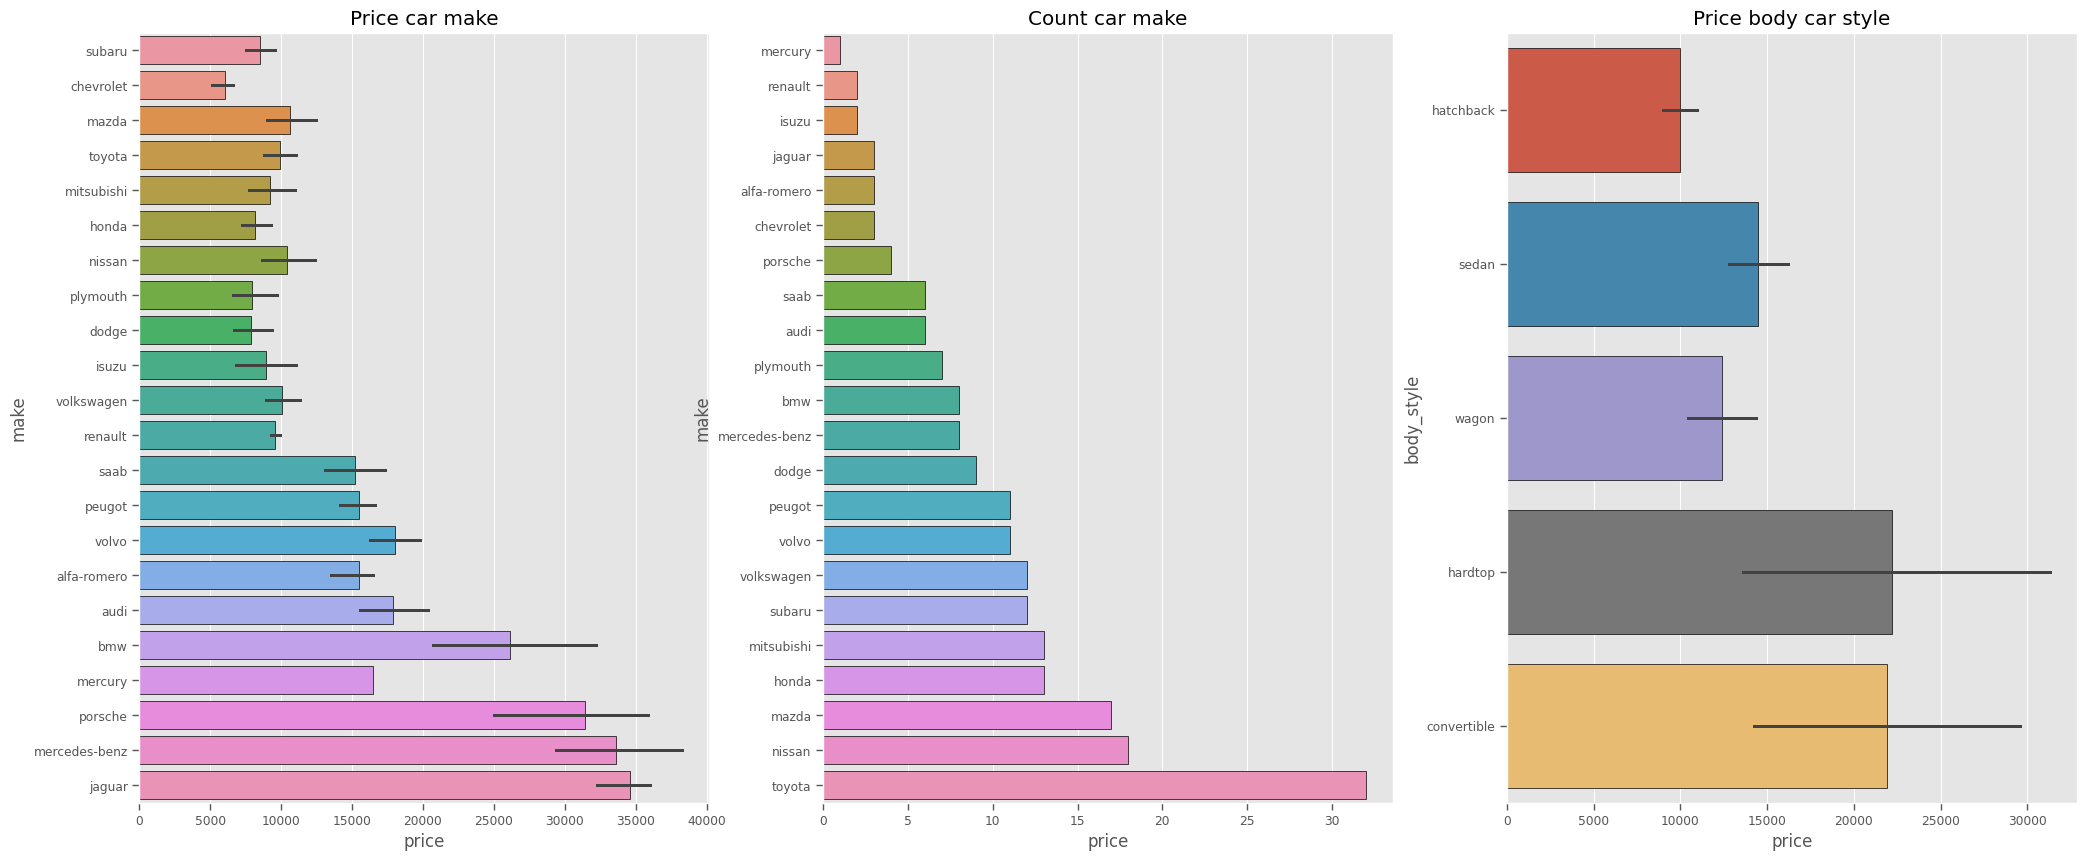

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10))
axes[0].set(title="Price car make", xlabel=None)
axes[1].set(title="Count car make", xlabel=None)
axes[2].set(title="Price body car style", xlabel=None)
sns.barplot(data=df.sort_values(["price"]),
            ax=axes[0],y="make",x="price",edgecolor="black",linewidth=0.5)
sns.barplot(data=df.groupby(["make"], as_index=False).count().sort_values(["price"]),
            ax=axes[1],y="make",x="price",edgecolor="black",linewidth=0.5,)
sns.barplot(data=df.sort_values(["price"]), 
            ax=axes[2],y="body_style", x="price",edgecolor="black",linewidth=0.5,)

In [15]:
def organize(data, titles:[], target='price'):
    set_x = data.loc[:,titles]
    y = set_x[target]
    set_x = set_x.drop(target, axis=1)
    return set_x.values.tolist(), y.values.tolist()

title_character = [ "wheel_base",
                    "num_of_cylinders",
                    "num_of_doors",
                    "length",
                    "width",
                    "height",
                    "curb_weight",
                    "engine_size",
                    "bore",
                    "stroke",
                    "compression_ratio",
                    "horsepower",
                    "peak_rpm",
                    "city_mpg",
                    "highway_mpg",
                    "price"]

x, y = organize(df, title_character)
LIMIT = len(x)
print(df.num_of_doors.dtype)
x_set = x[0:LIMIT]
y = y[0:LIMIT]
clf = RandomForestRegressor(n_estimators = 50, random_state = 123)
clf.fit(x_set, y)

sorted(np.round(clf.feature_importances_, 4), reverse=True)

int32


[0.6325,
 0.2124,
 0.0633,
 0.0132,
 0.0125,
 0.0096,
 0.0092,
 0.0092,
 0.0074,
 0.0067,
 0.0067,
 0.0061,
 0.0051,
 0.005,
 0.0012]

<BarContainer object of 15 artists>

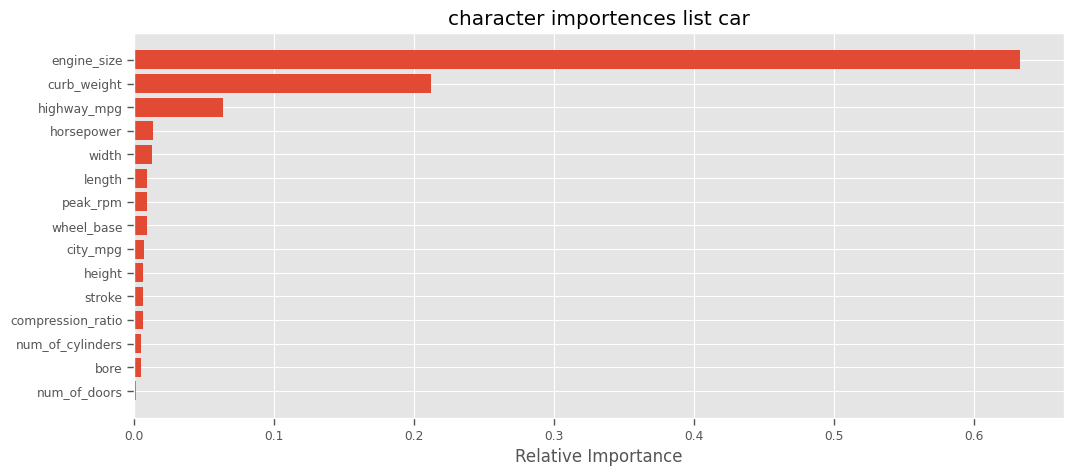

In [16]:
fig, ax=plt.subplots(figsize=(12,5))
importances = clf.feature_importances_
indices =np.argsort(importances)
ax.set(title="character importences list car", xlabel="Relative Importance", ylabel=None)
plt.yticks(range(len(indices)),np.array(title_character)[indices])
ax.barh(range(len(indices)), importances[indices])

<AxesSubplot:xlabel='normalized_losses', ylabel='price'>

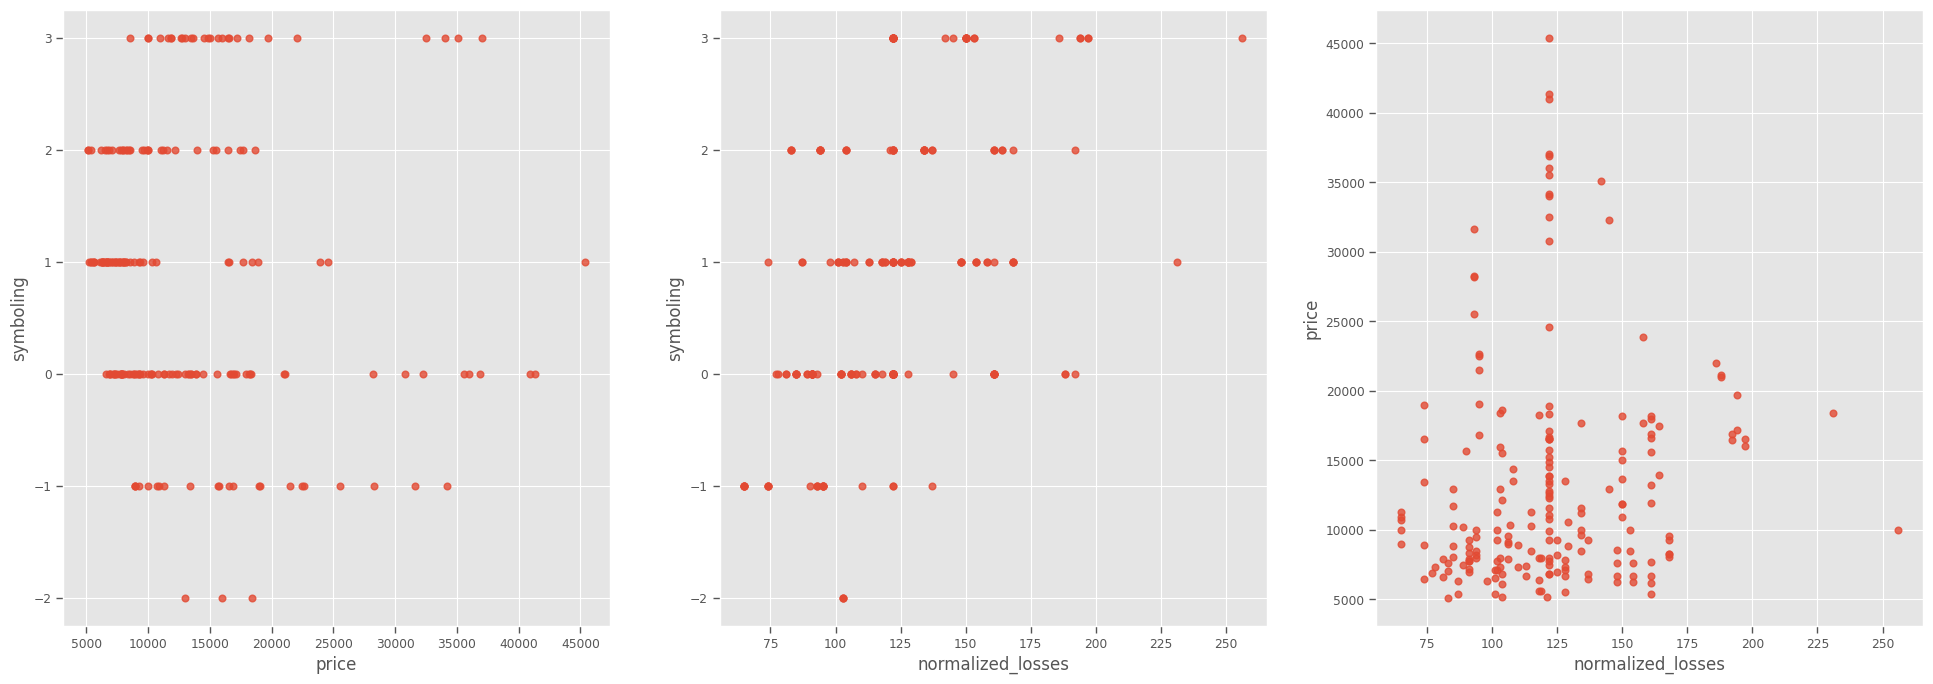

In [17]:
fig, axes = plt.subplots(1,3, figsize=(24,24/3))
sns.regplot(ax=axes[0],x="price", y="symboling", data=df, fit_reg=False)
sns.regplot(ax=axes[1],x="normalized_losses", y="symboling", data=df, fit_reg=False)
sns.regplot(ax=axes[2],x="normalized_losses", y="price", data=df, fit_reg=False)

In [18]:
grouped_df = df.loc[:,["price","engine_type","body_style"]].groupby(["engine_type","body_style"],as_index=False).mean().sort_values(["price"])
grouped_pivot = grouped_df.pivot(index='engine_type',columns='body_style')
grouped_pivot

price                                                   
body_style  convertible  hardtop     hatchback         sedan         wagon
engine_type                                                               
dohc            14997.5      NaN  15061.000000  22281.600000  15750.000000
l                   NaN      NaN   5151.000000  15758.571429  15017.500000
ohc             14632.0  13142.4   9001.153846  13134.070423  12114.133333
ohcf            37028.0  33278.0   6591.333333   9070.600000   9342.000000
ohcv            35056.0  45400.0  17949.250000  26604.500000  14399.000000
rotor               NaN      NaN  13020.000000           NaN           NaN

In [19]:
grouped_pivot = grouped_pivot.fillna(0) #fill missing values with 0
grouped_pivot

price                                                   
body_style  convertible  hardtop     hatchback         sedan         wagon
engine_type                                                               
dohc            14997.5      0.0  15061.000000  22281.600000  15750.000000
l                   0.0      0.0   5151.000000  15758.571429  15017.500000
ohc             14632.0  13142.4   9001.153846  13134.070423  12114.133333
ohcf            37028.0  33278.0   6591.333333   9070.600000   9342.000000
ohcv            35056.0  45400.0  17949.250000  26604.500000  14399.000000
rotor               0.0      0.0  13020.000000      0.000000      0.000000

[Text(0.5, 0, 'convertible'),
 Text(1.5, 0, 'hatchback'),
 Text(2.5, 0, 'sedan'),
 Text(3.5, 0, 'wagon'),
 Text(4.5, 0, 'hardtop')]

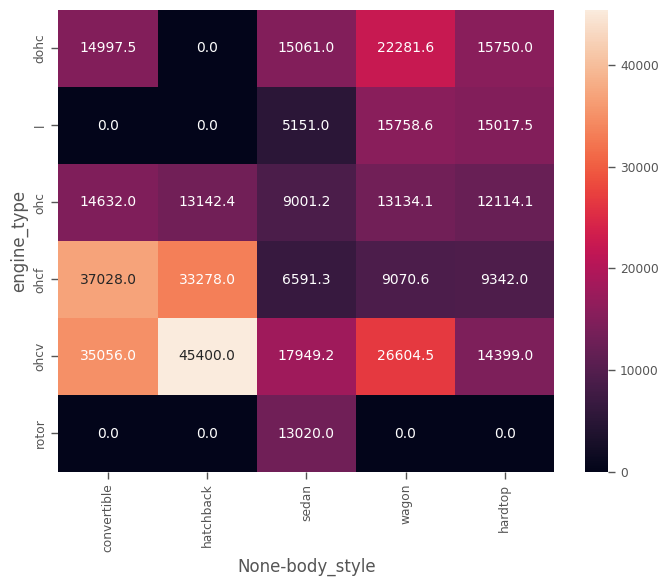

In [32]:
fig, axes = plt.subplots(figsize=(8,6))
sns.heatmap(grouped_pivot, annot=True, fmt=".1f")
axes.set_xticklabels(labels=df.body_style.unique(), rotation=90)

In [29]:
def set_pivot(index:str, column:str):
    grouped_df = df.loc[:,["price",index,column]].groupby([index,column],as_index=False).mean().sort_values([column])
    grouped_pivot = grouped_df.pivot(index=index,columns=column)
    return grouped_pivot.fillna(0)

[Text(0.5, 0, 'convertible'),
 Text(1.5, 0, 'hatchback'),
 Text(2.5, 0, 'sedan'),
 Text(3.5, 0, 'wagon'),
 Text(4.5, 0, 'hardtop')]

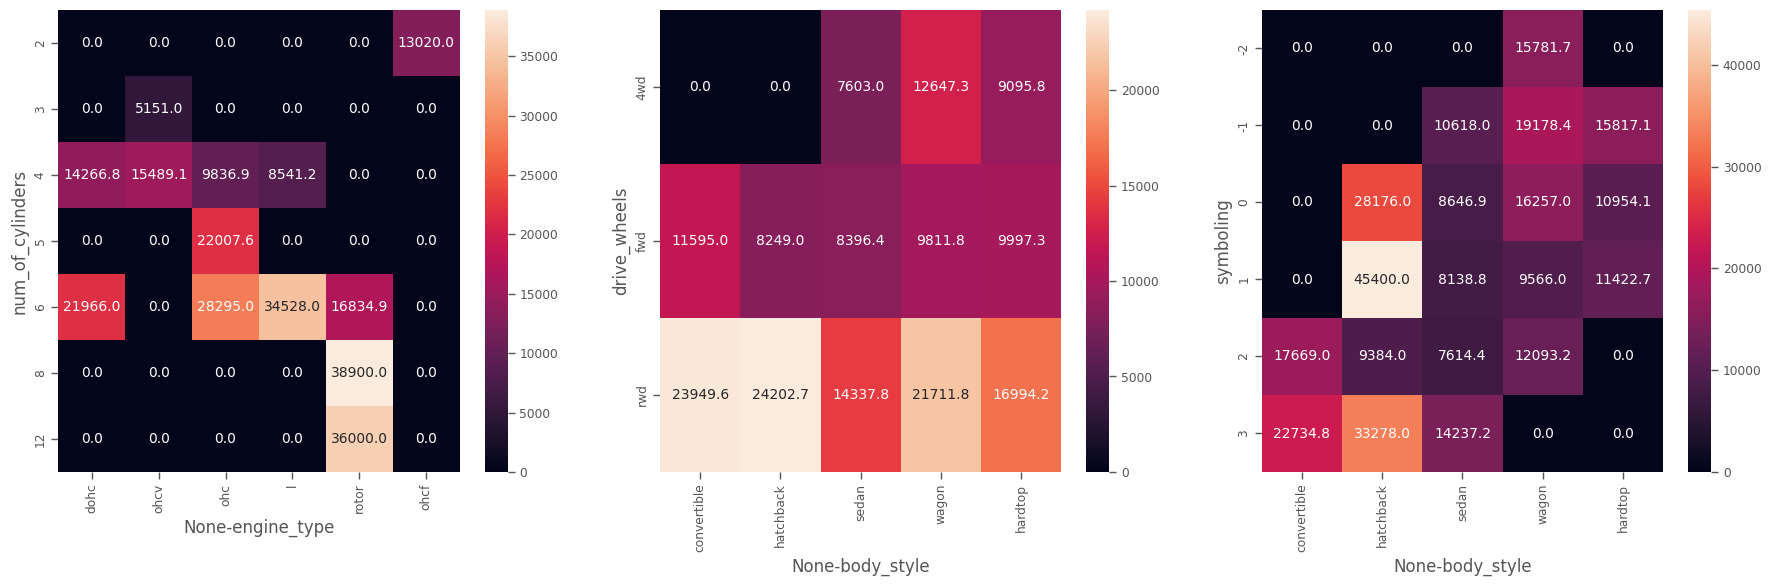

In [50]:
fig, axes = plt.subplots(1,3,figsize=(22,6))
sns.heatmap(set_pivot("num_of_cylinders", "engine_type"), annot=True, fmt=".1f", ax=axes[0])
axes[0].set_xticklabels(labels=df.engine_type.unique(), rotation=90)
sns.heatmap(set_pivot("drive_wheels", "body_style"), annot=True, fmt=".1f", ax=axes[1])
axes[1].set_xticklabels(labels=df.body_style.unique(), rotation=90)
sns.heatmap(set_pivot("symboling", "body_style"), annot=True, fmt=".1f", ax=axes[2])
axes[2].set_xticklabels(labels=df.body_style.unique(), rotation=90)